In [17]:
import numpy as np
import pickle
from astropy.io import fits
import astropy.units as u
from pathlib import Path
from IPython.display import clear_output
from importlib import reload
import copy

import falco
import proper
import roman_phasec_proper as phasec

import falco_utils as falcou
import misc

import hlc_band1_custom_config as config
reload(config)

npsf = 64

output_dir = Path('/home/u21/kianmilani/src/pyfalco/data/brief/')

flatmaps_dir = Path('/home/u21/kianmilani/Documents/falco-roman-cgi-dark-holes/flatmaps')
dm1_design = fits.getdata(flatmaps_dir/'dm1_m_design_hlc_band1.fits')
dm2_design = fits.getdata(flatmaps_dir/'dm2_m_design_hlc_band1.fits')
dm1_flatmap = fits.getdata(flatmaps_dir/'dm1_m_flat_hlc_band1.fits')
dm2_flatmap = fits.getdata(flatmaps_dir/'dm2_m_flat_hlc_band1.fits')

/home/u21/kianmilani/src/pyfalco/falco/config


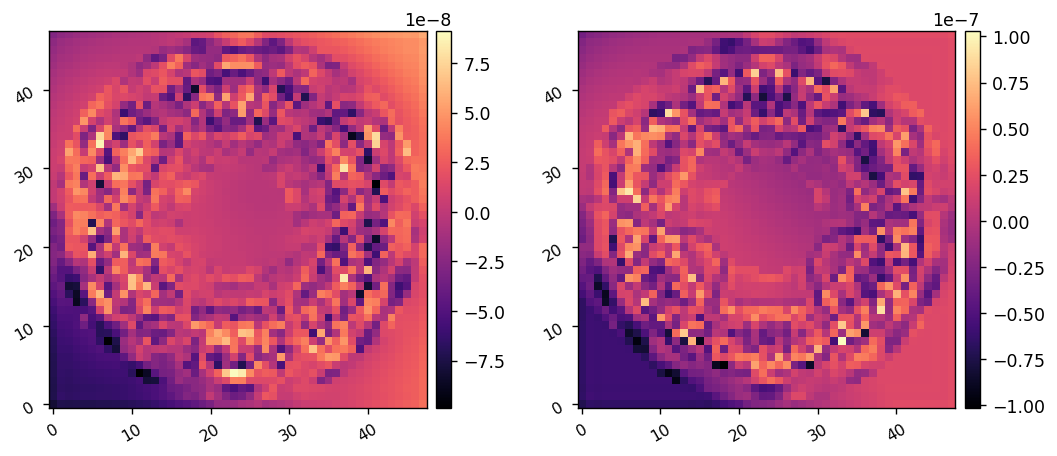

In [2]:
reload(config)

mp = config.setup(N_subpass=1, N_waves_per_subpass=1, fractional_bandwidth=0.01,
                  estimator='perfect', 
                  N_iterations=5,
                  spatial_weighting=[],
                  dark_hole_sides='r',
#                   dm1_initial=dm1_flatmap, dm2_initial=dm2_flatmap,
                  dm1_initial=dm1_flatmap+dm1_design, dm2_initial=dm2_flatmap+dm2_design,
                  label='hlc_band1_config_r_design')

misc.myimshow2(mp.full.dm1.flatmap, mp.full.dm2.flatmap)

out_fname = mp.runLabel + '_snippet.pkl'
with open(str(output_dir/out_fname), 'rb') as f: data = pickle.load(f)

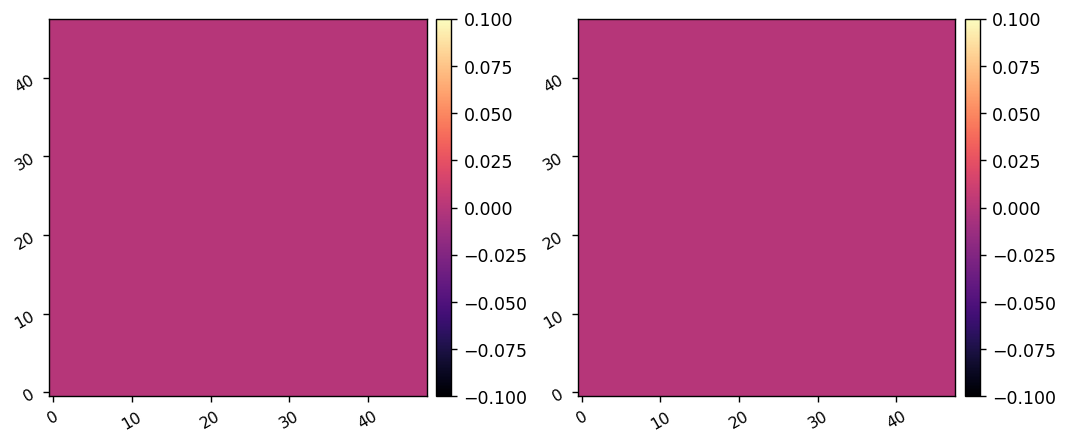

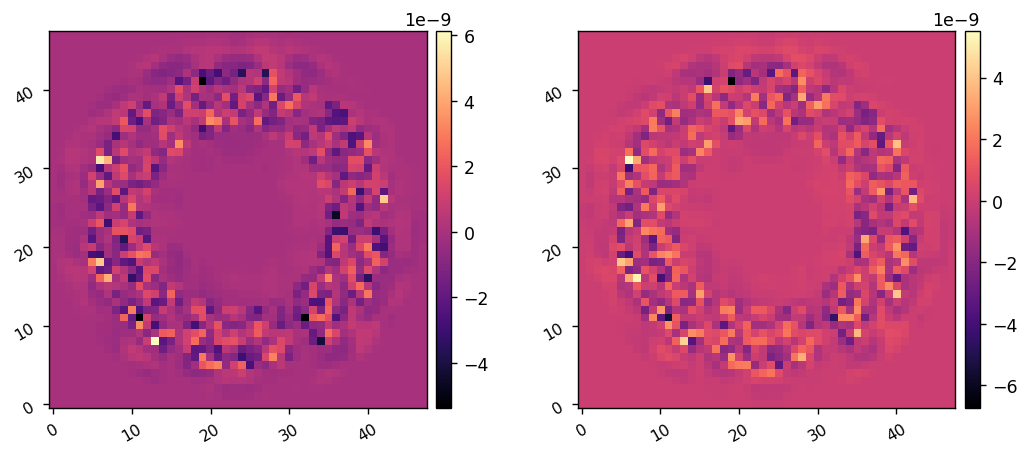

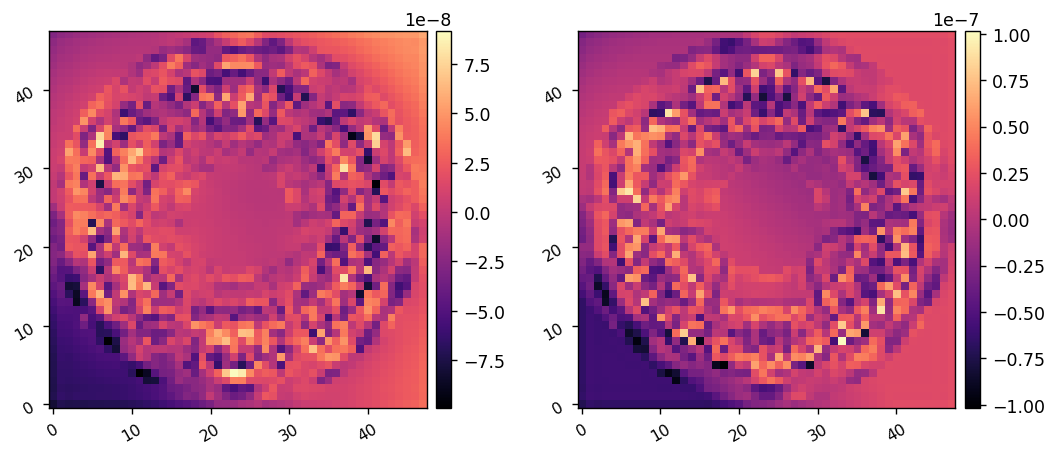

In [4]:
falco_dm1_ref = data.dm1.Vall[:,:,0]*mp.dm1.VtoH
falco_dm2_ref = data.dm2.Vall[:,:,0]*mp.dm2.VtoH
falco_dm1_final = data.dm1.Vall[:,:,-1]*mp.dm1.VtoH
falco_dm2_final = data.dm2.Vall[:,:,-1]*mp.dm2.VtoH 

misc.myimshow2(falco_dm1_ref, falco_dm2_ref)
misc.myimshow2(falco_dm1_final, falco_dm2_final)
misc.myimshow2(falco_dm1_final+mp.full.dm1.flatmap, falco_dm2_final+mp.full.dm2.flatmap)

In [5]:
# dm1_m, dm2_m = (falco_dm1_ref+mp.full.dm1.flatmap, falco_dm2_ref+mp.full.dm2.flatmap)
dm1_m, dm2_m = (falco_dm1_final+mp.full.dm1.flatmap, falco_dm2_final+mp.full.dm2.flatmap)

options = {'cor_type':mp.full.cor_type,
           'final_sampling_lam0':mp.full.final_sampling_lam0, 
           'source_x_offset':0,
           'use_errors': mp.full.use_errors,
           'use_lens_errors':mp.full.use_lens_errors,
           'use_dm1':1, 'dm1_m':dm1_m, 
           'use_dm2':1, 'dm2_m':dm2_m,
           'use_field_stop':mp.full.use_field_stop, 
           'field_stop_radius_lam0': mp.full.field_stop_radius_lam0,
           'polaxis':mp.full.polaxis,
          }

In [6]:
options.update({'source_x_offset':0})

lam_array = np.array([mp.lambda0*1e6])
(wfs, wfs_sampling_m) = proper.prop_run_multi('roman_phasec', lam_array, npsf, QUIET=False, PASSVALUE=options)
clear_output()

psfs = np.abs(wfs)**2
psf = psfs[0]
psf_pixelscale = wfs_sampling_m[0]*u.m/u.pix

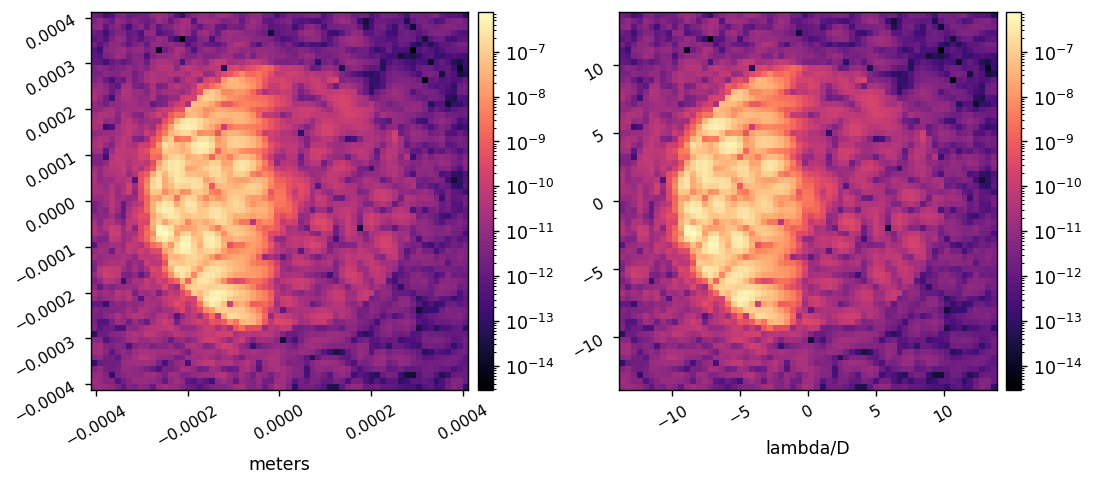

In [7]:
misc.myimshow2(psf, psf, lognorm1=True, lognorm2=True, pxscl1=psf_pixelscale, pxscl2=mp.full.final_sampling_lam0,)

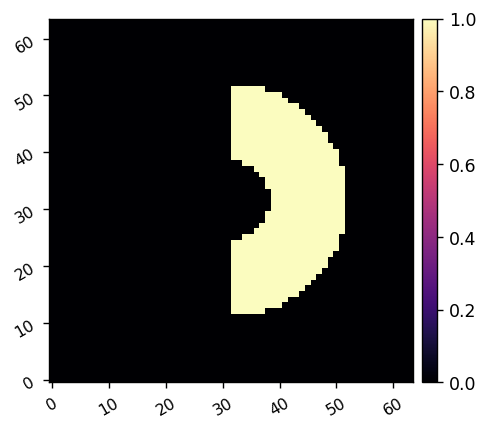

In [18]:
reload(falcou)
dh_params = {
    'inner_radius' : mp.Fend.score.Rin,
    'outer_radius' : mp.Fend.score.Rout,
    'edge_position' : 0,
    'direction' : mp.Fend.sides,
}

mask = falcou.create_annular_mask(dh_params, mp, npsf)
misc.myimshow(mask)

In [19]:
zone_radii = np.linspace(mp.Fend.score.Rin, mp.Fend.score.Rout, 
                         int(np.round(mp.Fend.score.Rout-mp.Fend.score.Rin) + 1))
zone_params = {
    'inner_radius' : zone_radii[0],
    'outer_radius' : zone_radii[1],
    'edge_position' : 0,
    'direction' : mp.Fend.sides,
}

lam_array = np.array([mp.lambda0*1e6])

In [20]:

opts = []
for i in range(len(zone_radii)-1):
    opts.append( copy.copy(options ) )
    opts[i].update( {'source_x_offset':(zone_radii[i] + zone_radii[i+1])/2} )
    print(opts[i]['source_x_offset'])
    
(wfs, wfs_sampling_m) = proper.prop_run_multi('roman_phasec', lam_array, npsf, QUIET=True, PASSVALUE=opts)
psfs = np.abs(wfs)**2
psf_offax = psfs[0]  
offax_psfs = np.abs(wfs)**2

3.5
4.5
5.5
6.5
7.5
8.5


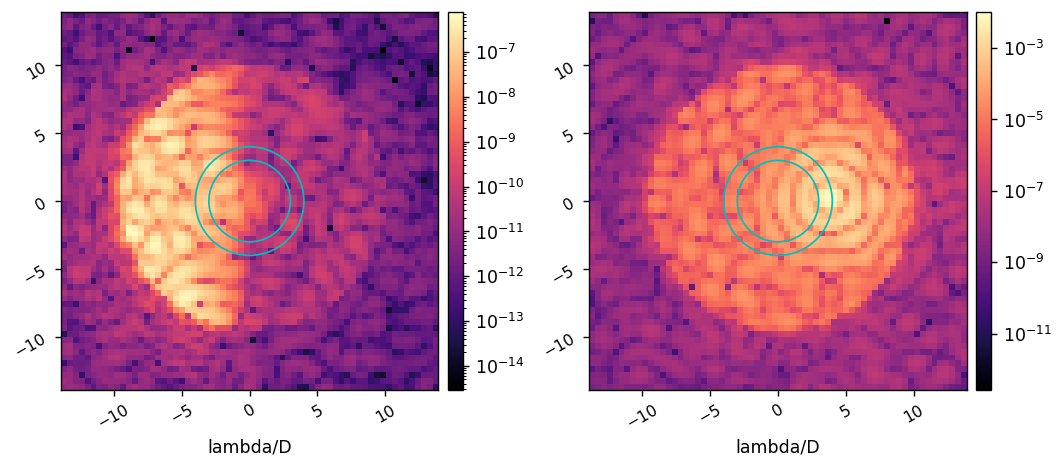

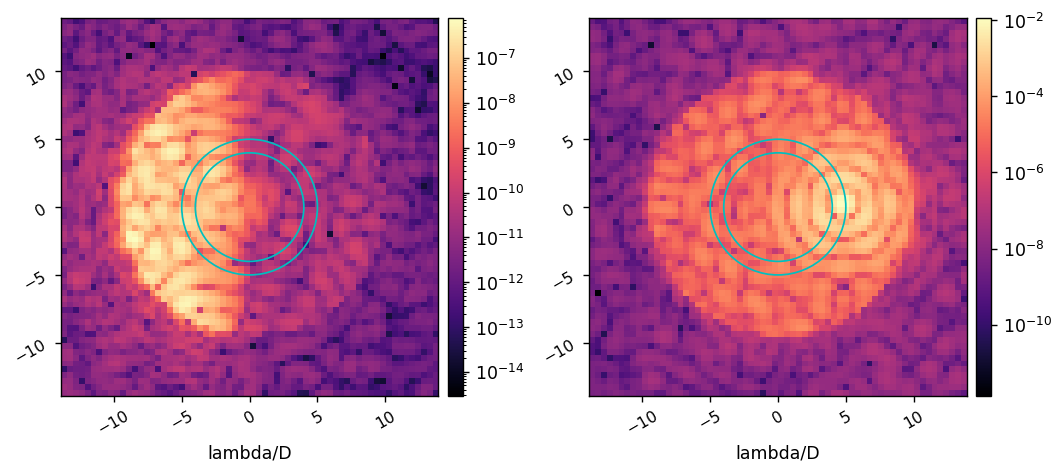

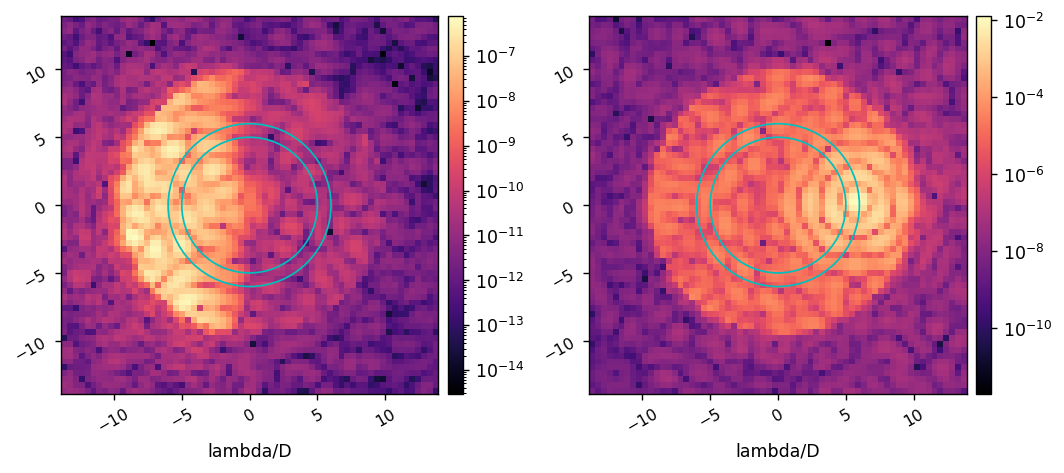

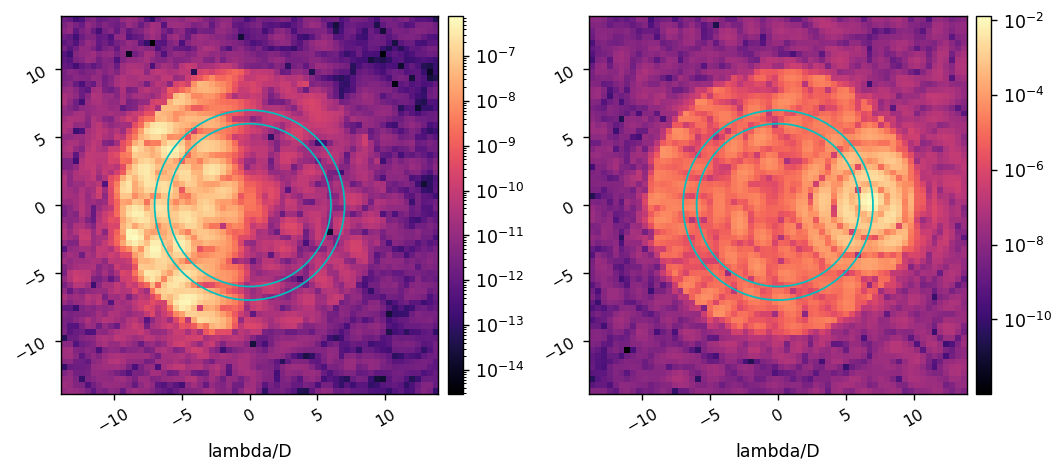

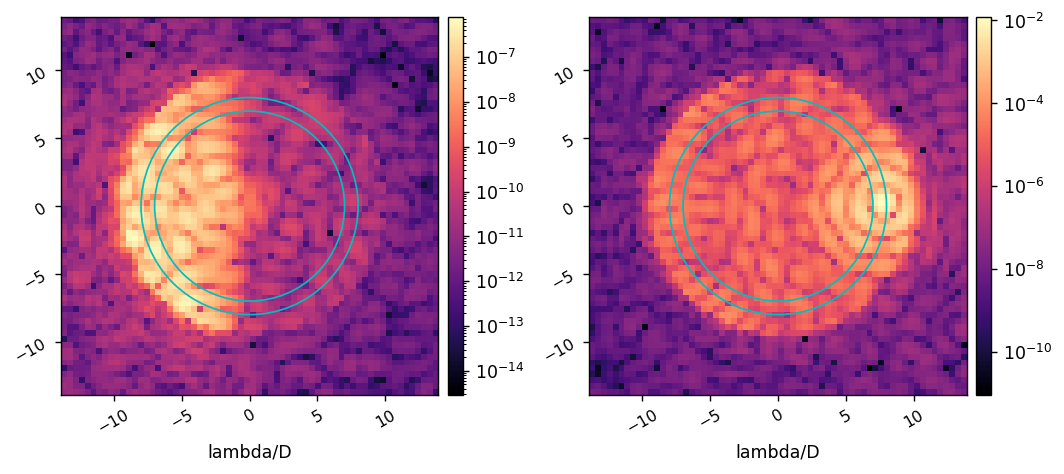

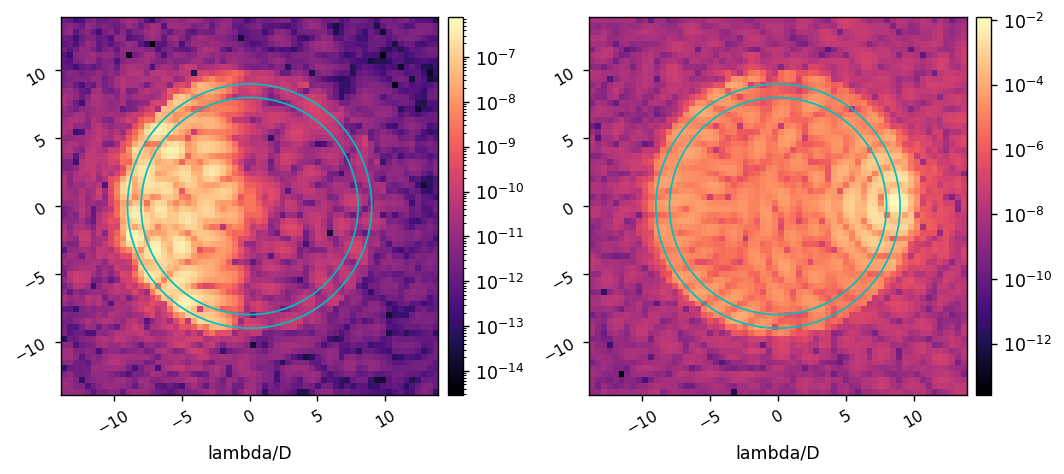

In [21]:
zone_contrasts = []

for i in range(len(zone_radii)-1):
    zone_params.update({'inner_radius' : zone_radii[i], 'outer_radius' : zone_radii[i+1],})
    zone_mask = falcou.create_annular_mask(zone_params, mp, npsf)
    psf_zone = zone_mask*psf
    zone_avg_flux = np.sum(psf_zone)/zone_mask.sum()
    
    zone_avg_contrast = zone_avg_flux/ np.max(offax_psfs[i])
    zone_contrasts.append(zone_avg_contrast)
    
    patches1 = falcou.create_circ_patches(zone_params)
    patches2 = falcou.create_circ_patches(zone_params)
    misc.myimshow2(psf, offax_psfs[i], lognorm1=True, lognorm2=True, 
                   pxscl1=mp.full.final_sampling_lam0, pxscl2=mp.full.final_sampling_lam0,
                   patches1=patches1, patches2=patches2)
    

In [22]:
reload(falcou)

falcou.zone_table(zone_radii, zone_contrasts)


╒════════╤════════════════╤════════════════╤═════════════════════╕
│   Zone │   Inner Radius │   Outer Radius │   Zone Avg Contrast │
╞════════╪════════════════╪════════════════╪═════════════════════╡
│      0 │            3.0 │            4.0 │           6.096e-09 │
├────────┼────────────────┼────────────────┼─────────────────────┤
│      1 │            4.0 │            5.0 │           5.108e-09 │
├────────┼────────────────┼────────────────┼─────────────────────┤
│      2 │            5.0 │            6.0 │           3.024e-09 │
├────────┼────────────────┼────────────────┼─────────────────────┤
│      3 │            6.0 │            7.0 │           3.570e-09 │
├────────┼────────────────┼────────────────┼─────────────────────┤
│      4 │            7.0 │            8.0 │           4.486e-09 │
├────────┼────────────────┼────────────────┼─────────────────────┤
│      5 │            8.0 │            9.0 │           5.134e-09 │
╘════════╧════════════════╧════════════════╧══════════════════